In [1]:
 #Import All Libraries Here
import pandas as pd
from sklearn.metrics import accuracy_score ,  roc_curve, auc , classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

import xgboost as xgb 
import statistics
from scipy.fftpack import fft, ifft


from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import RandomOverSampler


In [26]:
# Record Constants
INPUT_TRAIN_IN = "../../data/train_in.csv"
INPUT_TRAIN_OUT = "../../data/train_out.csv"  
INPUT_TEST_IN = "../../data/test_in.csv"
INPUT_TEST_OUT = "../../data/test_out.csv"

TARGET_MODEL_PATH = '../../webapp/model_files'

WINDOW_SIZE =  100 # Final RNA Sequence will be 101 Length 
MAX_LENGTH = (WINDOW_SIZE * 2)+1
ENCODING_METHOD = 1 # 1 - ANF Encoding , 2 - One Hot Encoding  
PERFORM_DATA_BALANCING = False

In [18]:
#Read X Varaibles and Y Varaibles

x_train_raw =  pd.read_csv(INPUT_TRAIN_IN, header=None , skiprows=1  , nrows = 100)
y_train_raw =  pd.read_csv(INPUT_TRAIN_OUT, header=None , skiprows=1 , nrows = 100)

x_test_raw =  pd.read_csv(INPUT_TEST_IN, header=None , skiprows=1)
y_test_raw =  pd.read_csv(INPUT_TEST_OUT, header=None , skiprows=1)

### Apply ANF Encoding 

In [4]:
# Apply ANF Encoding on Input Features
def apply_accumulated_nucle_frequency(seq):
    mapping = []
    A = 0
    C = 0
    T = 0
    G = 0
    for i, v in seq.items():
        if v == 'A':
            A += 1
            mapping.append(A / (i + 1))
        elif v == 'C':
            C += 1
            mapping.append(C / (i + 1))
        elif v == 'T' or v == 'U':
            T += 1
            mapping.append(T / (i + 1))
        else:
            G += 1
            mapping.append(G / (i + 1))
    padding = (MAX_LENGTH - len(mapping))
    mapping = np.pad(mapping, (0, padding), 'constant')
    return mapping

In [8]:
# # Encode X Features Based on Middle Index
def encode_using_anf(x_train_raw):
    middle_index = (x_train_raw.shape[1] // 2) + 1
    truncated_df = x_train_raw.iloc[:, middle_index - WINDOW_SIZE - 1: middle_index + WINDOW_SIZE]
    result = truncated_df.apply(apply_accumulated_nucle_frequency, axis=1)
    return result 

### Apply One Hot Encoding

In [19]:
# Create One Hot Encoding for RNA Sequence 
def one_hot_encode_sequence(seq):
    bases = 'ACGT'
    base_dict = {base: i for i, base in enumerate(bases)}
    one_hot = np.zeros((len(seq), len(bases)))
    for i, base in enumerate(seq):
        if base == 'N':
            continue
        one_hot[i, base_dict[base]] = 1
    return one_hot.flatten()


# Encode X Features Based on Middle Index
def encode_x_with_in_hot(x_train_raw):
    middle_index = (x_train_raw.shape[1] // 2) + 1
    truncated_df = x_train_raw.iloc[:, middle_index -1 : middle_index + WINDOW_SIZE ] # Window Starts from V501 with 50 window size
    truncated_df['Sequence'] = truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
    print(truncated_df)
    result =  truncated_df['Sequence'].apply(one_hot_encode_sequence)
    return result 



### Perform Encoding of X Features

In [31]:
# Apply Encoding Method

if ENCODING_METHOD == 1:
    x_encoded = encode_using_anf(x_train_raw).tolist()

if ENCODING_METHOD == 2:
    x_train = pd.DataFrame()
    x_train['one_hot_encoded'] = encode_x_with_in_hot(x_train_raw)
    x_encoded = np.array(x_train['one_hot_encoded'].tolist())
    

### Encode Each Y category to 0 to 12 classes.

In [29]:
#Decode Y to its Original Form . Additional Class - NonMoD added for Non Modified RNA Sequence 
RMs = ['hAm','hCm','hGm','hTm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol','NonMoD']
RMEncoding = [0,1,2,3,4,5,6,7,8,9,10,11,12]

def decode_y(row):   
    decoded = ''
    for index , n in enumerate(row.tolist()) :
        if n == 1 :
            decoded = RMEncoding[index]
    
    if decoded == '':
        return 12
    
    return decoded 

y_encoded =  y_train_raw.apply(decode_y , axis=1)
y_encoded.value_counts()

0    100
dtype: int64

### Create Sample Data for Training and Testing

In [32]:
# Create Train anf Test Data for Model training - 80:20 Split 
X_train, X_test, y_train, y_test = train_test_split(x_encoded, y_encoded, test_size=0.2, random_state=42)

X_train

[array([0.00249377, 0.00248756, 0.00496278, 0.00247525, 0.00493827,
        0.00738916, 0.002457  , 0.00980392, 0.00733496, 0.00487805,
        0.01216545, 0.00970874, 0.00484262, 0.00724638, 0.01445783,
        0.00721154, 0.01678657, 0.01913876, 0.00954654, 0.02142857,
        0.00950119, 0.02369668, 0.01182033, 0.01179245, 0.01411765,
        0.01643192, 0.02576112, 0.01168224, 0.01864802, 0.02790698,
        0.01392111, 0.0162037 , 0.01385681, 0.01843318, 0.02988506,
        0.03211009, 0.01601831, 0.03424658, 0.03644647, 0.03863636,
        0.04081633, 0.02036199, 0.04288939, 0.04504505, 0.04719101,
        0.02242152, 0.049217  , 0.02008929, 0.02449889, 0.02666667,
        0.01773836, 0.02876106, 0.01986755, 0.05066079, 0.05274725,
        0.05482456, 0.05689278, 0.02183406, 0.02178649, 0.02391304,
        0.02603037, 0.02813853, 0.03023758, 0.05818966, 0.03225806,
        0.03433476, 0.03640257, 0.03846154, 0.05970149, 0.02340426,
        0.02972399, 0.04025424, 0.03171247, 0.03

### Re-Sample Data Using Smote

In [15]:
#Code Reference : https://github.com/dmlc/xgboost/blob/master/demo/multiclass_classification/train.py

# PERFORM_DATA_BALANCING - if True then code will perform over sampling for each category.
if PERFORM_DATA_BALANCING:
    sm = RandomOverSampler(random_state=42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    print(y_train.value_counts())

### Train using XGBoost 

In [33]:

# Define XGBoost parameters
params = {
    'objective': 'multi:softmax',
    'num_class': 13,
    'max_depth': 4,
    'n_jobs': -1,
    'enable_categorical': True
}

# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# Train XGBoost model
num_rounds = 100
model = xgb.train(params, dtrain, num_rounds)

# Make predictions on test set
y_pred = model.predict(dtest)


[17:43:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "enable_categorical" } are not used.



### Calculate Accuracy

In [34]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


Accuracy of XGBoost  model: 0.64


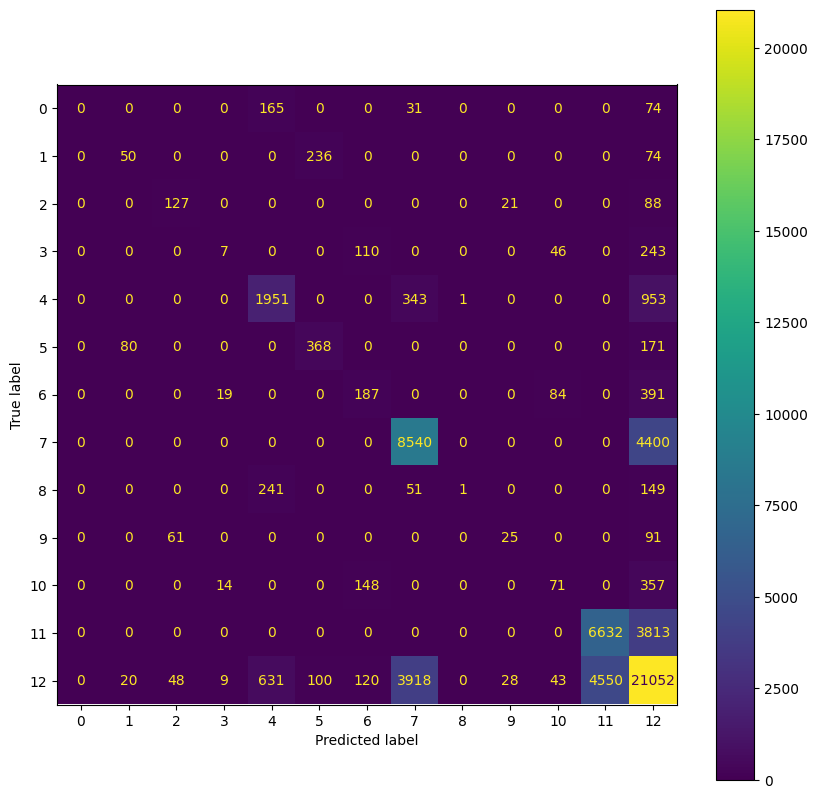

In [17]:
# Plot confusion matrix 
cm = confusion_matrix(y_test, y_pred, labels=np.array(RMEncoding))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.array(RMEncoding))

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))

## Save Model 

In [13]:
import pickle

TARGET_MODEL_PATH += '/xgboost_model.bin'

##dump the model into a file
with open(TARGET_MODEL_PATH, 'wb') as f_out:
    pickle.dump(bst, f_out) # write final_model in .bin file
    f_out.close()  # close the file 
    print("Exported Model Successfully")  

Exported Model Successfully


#  ---------------------- Further Feature Extraction with ANF Fourier Transform -----------------------------------

In [14]:
def feature_extraction(features, spectrum, spectrumTwo):
    average = sum(spectrum) / len(spectrum)
    features.append(average)
    ###################################
    median = np.median(spectrum)
    features.append(median)
    ###################################
    maximum = np.max(spectrum)
    features.append(maximum)
    ###################################
    minimum = np.min(spectrum)
    features.append(minimum)
    ###################################
    peak = (len(spectrum) / 3) / (average)
    features.append(peak)
    ###################################
    peak_two = (len(spectrumTwo) / 3) / (np.mean(spectrumTwo))
    features.append(peak_two)
    ###################################
    standard_deviation = np.std(spectrum)  # standard deviation
    features.append(standard_deviation)
    ###################################
    standard_deviation_pop = statistics.stdev(spectrum)  # population sample standard deviation
    features.append(standard_deviation_pop)
    ###################################
    percentile15 = np.percentile(spectrum, 15)
    features.append(percentile15)
    ###################################
    percentile25 = np.percentile(spectrum, 25)
    features.append(percentile25)
    ###################################
    percentile50 = np.percentile(spectrum, 50)
    features.append(percentile50)
    ###################################
    percentile75 = np.percentile(spectrum, 75)
    features.append(percentile75)
    ###################################
    amplitude = maximum - minimum
    features.append(amplitude)
    ###################################
    # mode = statistics.mode(spectrum)
    ###################################
    variance = statistics.variance(spectrum)
    features.append(variance)
    ###################################
    interquartile_range = np.percentile(spectrum, 75) - np.percentile(spectrum, 25)
    features.append(interquartile_range)
    ###################################
    semi_interquartile_range = (np.percentile(spectrum, 75) - np.percentile(spectrum, 25)) / 2
    features.append(semi_interquartile_range)
    ###################################
    coefficient_of_variation = standard_deviation / average
    features.append(coefficient_of_variation)
    ###################################
    skewness = (3 * (average - median)) / standard_deviation
    features.append(skewness)
    ###################################
    kurtosis = (np.percentile(spectrum, 75) - np.percentile(spectrum, 25)) / (
            2 * (np.percentile(spectrum, 90) - np.percentile(spectrum, 10)))
    features.append(kurtosis)
    ###################################
    return

def accumulated_nucle_frequency_fourier(seq):
    mapping = []
    spectrumTwo = []
    spectrum = []
    features = []
    A = 0
    C = 0
    T = 0
    G = 0
    
    for i , v in seq.items():
        if v == 'A':
            A += 1
            mapping.append(A / (i + 1))
        elif v == 'C':
            C += 1
            mapping.append(C / (i + 1))
        elif v == 'T' or seq[i] == 'U':
            T += 1
            mapping.append(T / (i + 1))
        else:
            G += 1
            mapping.append(G / (i + 1))
            
    Fmap = fft(mapping)
    for i in range(len(mapping)):
        specTotal = (abs(Fmap[i]) ** 2)
        specTwo = (abs(Fmap[i]))
        spectrum.append(specTotal)
        spectrumTwo.append(specTwo)
    feature_extraction(features, spectrum, spectrumTwo)
    return features


In [15]:
# # Encode with Fourier Transform 
# def encode_x_with_fourier(x_train_raw):
#     middle_index = (x_train_raw.shape[1] // 2) + 1
#     truncated_df = x_train_raw.iloc[:, middle_index - WINDOW_SIZE - 1: middle_index + WINDOW_SIZE]
#     result = truncated_df.apply(accumulated_nucle_frequency_fourier, axis=1)
#     return result 

# x_train_encoded_fourier = encode_x_with_fourier(x_train_raw)

# print(x_train_encoded_fourier.shape)

In [16]:
# # Train Model Again 

# x_train_f= x_train_encoded_fourier.tolist()
# y_train_f = y_train_original 

# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
# x_res_f, y_res_f = sm.fit_resample(x_train_f, y_train_f)

# #print("Shape of X Train : " , x_train.shape , " Shape of Y Train : " , y_train.shape)

# xg_train_f = xgb.DMatrix(x_res_f, label=y_res_f)

# # setup parameters for xgboost
# param = {}
# # use softmax multi-class classification
# param['objective'] = 'multi:softmax'
# # scale weight of positive examples
# param['eta'] = 0.1
# param['max_depth'] = 6
# param['nthread'] = 4
# param['num_class'] = 13


# num_round = 5
# xgb_f = xgb.train(param, xg_train_f, num_round)


In [17]:
# # Predict Accuracy
# y_test=  y_test_raw.apply(decode_y , axis=1)

# x_test = encode_x_with_fourier(x_test_raw).tolist()
# xg_test = xgb.DMatrix(x_test, label=y_test)

# y_pred = xgb_f.predict(xg_test)

# print(y_pred)

# # Calculate the accuracy score of the xgboost regression model
# accuracy = accuracy_score(y_test, y_pred)

# print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))



# ------- Use One Hot Encoding ------------------

In [12]:
# Encode using one-hot encoding 
def apply_one_hot_encode(sequence):
    nucleotides = ['C', 'A', 'T', 'G']
    one_hot = []
    for nucleotide in sequence:
        # For G - [0,0,1,0]
        if nucleotide == 'N': # N is not application , used for empty values.
            hot = [0,0,0,0]
        else:
            hot = [0 if nucleotide != nt else 1 for nt in nucleotides]

        one_hot.append(hot)
    return np.array(one_hot).flatten()
    # Apply flatten to make feature 2 Dimensional as Logistic Regression only support 2D matrix as features.


# Encode X Features Based on Middle Index
def encode_x_with_in_hot(x_train_raw):
    middle_index = (x_train_raw.shape[1] // 2) + 1
    truncated_df = x_train_raw.iloc[:, middle_index - WINDOW_SIZE - 1: middle_index + WINDOW_SIZE]
    print(truncated_df.shape)
    result = truncated_df.apply(apply_one_hot_encode, axis=1)
    return result 

x_encoded = encode_x_with_in_hot(x_train_raw)


(120000, 51)


In [10]:
#Decode Y to its Original Form . Additional Class - NonMoD added for Non Modified RNA Sequence 
RMs = ['hAm','hCm','hGm','hTm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol','NonMoD']
RMEncoding = [0,1,2,3,4,5,6,7,8,9,10,11,12]

def decode_y(row):   
    decoded = ''
    for index , n in enumerate(row.tolist()) :
        if n == 1 :
            decoded = RMs[index]
    
    if decoded == '':
        return 'NonMoD'
    
    return decoded 

y_train_original =  y_train_raw.apply(decode_y , axis=1)
y_train_original.value_counts()

hm6A      61931
NonMoD    29030
hm1A      16141
hm5U       3496
hm5C       3007
hTm        2053
hCm        1678
hAm        1391
hGm        1271
hm6Am         2
dtype: int64

In [23]:
#Code Reference : https://github.com/dmlc/xgboost/blob/master/demo/multiclass_classification/train.py
x_train= x_encoded.tolist()
y_train = y_train_original 

from imblearn.over_sampling import SMOTE
sm = RandomOverSampler(random_state=42 )
x_res, y_res = sm.fit_resample(x_train, y_train)


print(y_res.value_counts())

hAm       61931
NonMoD    61931
hm6Am     61931
hCm       61931
hGm       61931
hTm       61931
hm1A      61931
hm6A      61931
hm5C      61931
hm5U      61931
dtype: int64


In [22]:

clf = OneVsRestClassifier(xgb.XGBClassifier(n_jobs=-1, max_depth=4 , objective='multi:softmax' , num_class = 13))
clf.fit(x_res, y_res )


# xg_train = xgb.DMatrix(x_res, label=y_res)

# # setup parameters for xgboost
# param = {}
# # use softmax multi-class classification
# param['objective'] = 'multi:softmax'
# # scale weight of positive examples
# param['eta'] = 0.1
# param['max_depth'] = 6
# param['nthread'] = 4
# param['num_class'] = 13


# num_round = 5
# bst = xgb.train(param, xg_train, num_round)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_class=13,
                                            num_parallel_tree=None,
                                            objective='multi:softmax', ...))

In [24]:
y_test=  y_test_raw.apply(decode_y , axis=1)

x_test = encode_x_with_in_hot(x_test_raw).tolist()
# xg_test = xgb.DMatrix(x_test)
# y_pred = bst.predict(xg_test)

y_pred = clf.predict(x_test)

# Calculate the accuracy score of the xgboost regression model
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))

(1200, 51)
Accuracy of XGBoost  model: 0.55


Accuracy of XGBoost  model: 0.55


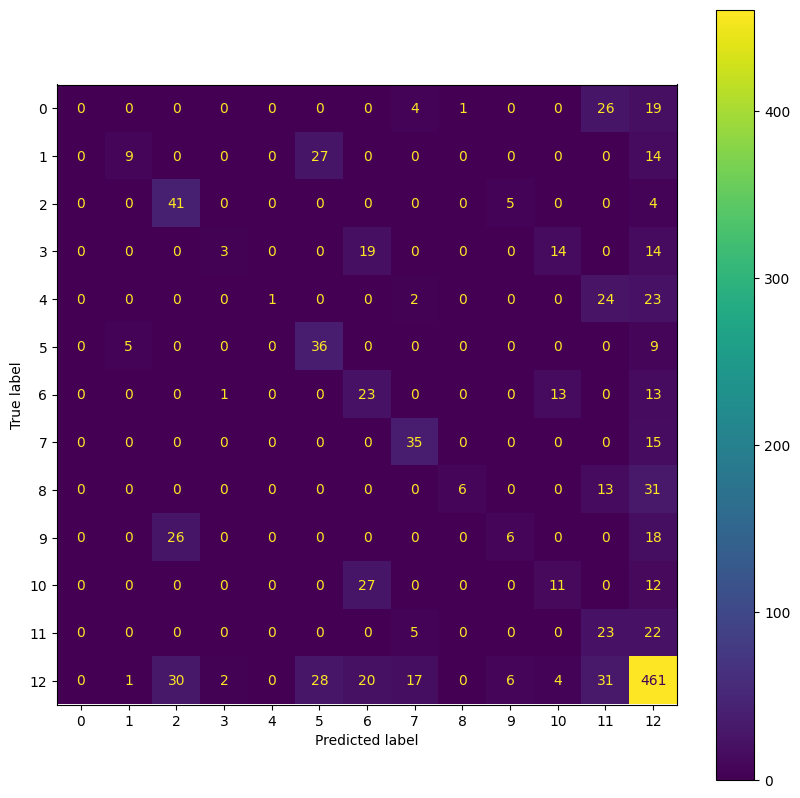

In [25]:
# Plot confusion matrix 
cm = confusion_matrix(y_test, y_pred, labels=np.array(RMEncoding))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.array(RMEncoding))

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))

In [24]:
from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(x_res, y_res)
svm_predictions = svm_model_linear.predict(x_test)
  
# model accuracy for X_test  
accuracy = svm_model_linear.score(x_test, y_test)
  
# creating a confusion matrix
cm = confusion_matrix(y_test, svm_predictions)

# LSTM Based Models

In [ ]:
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(1, input_seq.size(1), self.hidden_size).to(device)
        c0 = torch.zeros(1, input_seq.size(1), self.hidden_size).to(device)

        # Forward pass through LSTM layer
        output, (hidden, cell) = self.lstm(input_seq, (h0, c0))

        # Get the final output of the LSTM (last hidden state)
        final_output = hidden[-1, :, :]

        # Forward pass through fully connected layer
        output = self.fc(final_output)

        # Softmax activation function to get probabilities
        output = nn.functional.softmax(output, dim=1)
        return output


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

# # RNA sequences (input)
# train_data = [
#     'AUUGGCGCUUAC',
#     'AGCUGGGAGUUCAA',
#     'AUCUCAGGACAGUUGGCUUUGUUUGUCC',
#     # ...
# ]

# Target labels (output)
train_labels = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13
]

# One-hot encoding of RNA sequences
#base_to_idx = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
input_dim = 404  # A, C, G, 
max_len = 1001

train_data_oh = torch.from_numpy(X_train)


# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.view(len(input_seq), 1, -1))
        last_out = lstm_out[-1]
        out = self.fc(last_out)
        return out

# Initialize model and optimizer
hidden_dim = 16
output_dim = 13
model = LSTMModel(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters())

# Train model
num_epochs = 100
loss_fn = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    # for i in range(len(train_data_oh)):
    #     input_seq = train_data_oh[i]
    label = torch.tensor([train_labels[i]], dtype=torch.long)

    optimizer.zero_grad()
    output = model(train_data_oh)
    loss = loss_fn(output, label)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Test model
test_data = [
    'UCCUGGGUCCAGUUCUGCUUAAACUUAGUUGCCUAA',
    'AGCCUCUUGGGAUUGGGCUUUGUUUGUCC',
    # ...
]
MAX_SEQ_LEN = 200
test_data_oh = torch.zeros(len(test_data), MAX_SEQ_LEN, len(base_to_idx))
for i, seq in enumerate(test_data):
    for j, base in enumerate(seq):
        test_data_oh[i, j, base_to_idx[base]] = 1

with torch.no_grad():
    for i in range(len(test_data)):
        input_seq = test_data_oh[i]
        output = model(input_seq)
        predicted_label = torch.argmax(output).item()
        print('Test example {}: predicted label {}'.format(i+1, predicted_label))


RuntimeError: mat1 and mat2 must have the same dtype